In [1]:
import sys
sys.path.insert(1, '../Src')
import numpy as np
import pandas as pd
import os
from utils.feature_engineering import *
from utils.preprocessing import *
from utils.analysis import *
from utils_custom.analysis import *

import matplotlib.pyplot as plt
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings('ignore')

#PATH_DATASET = '../Dataset/'
PATH_DATASET = '../Dataset/data-h-m1-challenge-final'
PATH_RESULTS = '../Results/'

FILL = False

In [2]:
if FILL:
    print('FILL DATA')
    
    print('Reading dataset')
    df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','sales.pkl'))
    df_submission_sample = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','submission_sample.pkl'))

    df_release = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','grid_part_1.pkl'))
    
    df_sales = df_release[df_release['date_block_num']<=df_sales['date_block_num'].max()]
    df_submission_sample.merge(df_release[['date_block_num','S100','item_id','release']],on=['date_block_num','S100','item_id'],how='left')
    
    del df_release
    gc.collect()
    df_sales             = reduce_mem_usage(df_sales)
    df_submission_sample = reduce_mem_usage(df_submission_sample)
    gc.collect()
    print('df_sales size             :',df_sales.shape)
    print('df_submission_sample size :',df_submission_sample.shape)    
    
else:
    print('NO FILL DATA')

    print('Reading dataset')
    df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','sales.pkl'))
    df_submission_sample = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','submission_sample.pkl'))
    
    df_release = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','grid_part_1.pkl'))
    print('df_release size ',df_release.shape)
    
    df_submission_sample.merge(df_release[['date_block_num','S100','item_id','release']],on=['date_block_num','S100','item_id'],how='left')
    df_sales.merge(df_release[['date_block_num','S100','item_id','release']],on=['date_block_num','S100','item_id'],how='left')
    del df_release
    gc.collect()
    df_sales             = reduce_mem_usage(df_sales)
    df_submission_sample = reduce_mem_usage(df_submission_sample)
    gc.collect()
    print('df_sales size             :',df_sales.shape)
    print('df_submission_sample size :',df_submission_sample.shape)
    '''
    df_release size  (14635529, 9)
    Memory usage of dataframe is 167.81 MB
    Memory usage after optimization is: 152.23 MB
    Decreased by 9.3%
    Memory usage of dataframe is 4.75 MB
    Memory usage after optimization is: 6.71 MB
    Decreased by -41.3%
    df_sales size             : (2749369, 8)
    df_submission_sample size : (69121, 9)
    '''
    pass
    

NO FILL DATA
Reading dataset
df_release size  (14623646, 9)
Memory usage of dataframe is 135.27 MB
Memory usage after optimization is: 122.75 MB
Decreased by 9.3%
Memory usage of dataframe is 3.64 MB
Memory usage after optimization is: 5.63 MB
Decreased by -54.8%
df_sales size             : (2216312, 8)
df_submission_sample size : (52959, 9)


In [3]:
df_sales.head()

,DATE,S100,I100,C100,C101,QTT,item_id,date_block_num
0,2017-01-08,0,0,12,76,2,0_12_76,0
1,2017-01-08,0,0,12,149,3,0_12_149,0
2,2017-01-08,0,0,12,256,3,0_12_256,0
3,2017-01-08,0,0,12,354,3,0_12_354,0
4,2017-01-08,0,0,13,149,2,0_13_149,0


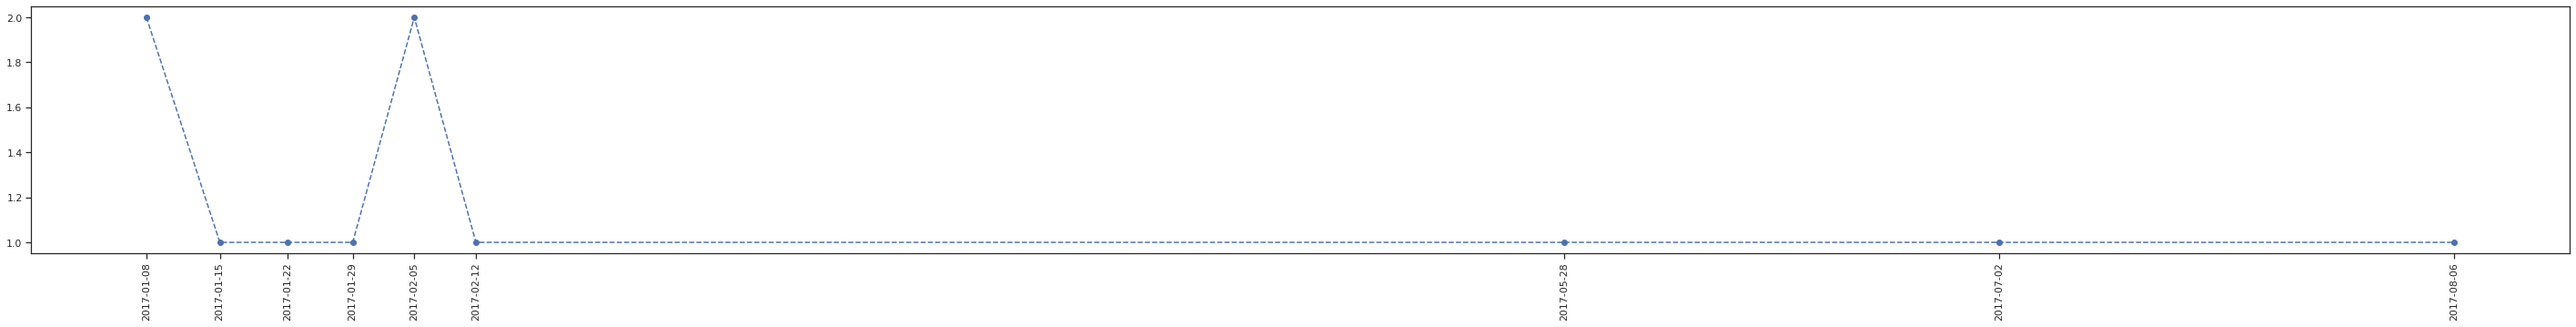

In [4]:
sub_group = get_store_item(df_sales,0,0,12,76)
sub_group.head()

fig = plt.figure(figsize=(50,5))
plt.plot(sub_group.index,sub_group['QTT'],'--o')
#plt.xticks(rotation=90)
plt.xticks(sub_group.index, sub_group['DATE'].astype(str), rotation=90)
plt.show()

In [5]:
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num
0,2021-12-19_0_1_12_76,-1,2021-12-19,0,1,12,76,1_12_76,258
1,2021-12-19_0_1_12_140,-1,2021-12-19,0,1,12,140,1_12_140,258
2,2021-12-19_0_1_12_164,-1,2021-12-19,0,1,12,164,1_12_164,258
3,2021-12-19_0_1_12_201,-1,2021-12-19,0,1,12,201,1_12_201,258
4,2021-12-19_0_1_12_339,-1,2021-12-19,0,1,12,339,1_12_339,258


# Add features 

In [6]:
############## item  and  store ##################################
df_items  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','item.pkl'))
df_stores = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','store.pkl'))

N_submission = df_submission_sample.shape[0]
N_sales      = df_sales.shape[0]

df_sales = df_sales.merge(df_items,on=['I100'])
df_sales = df_sales.merge(df_stores,on=['S100'])
    
df_submission_sample = df_submission_sample.merge(df_items,on=['I100'])
df_submission_sample = df_submission_sample.merge(df_stores,on=['S100'])

df_sales.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)

del df_items
del df_stores
gc.collect()

0

In [7]:
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,I102,I103,S101,S102,S103
0,2021-12-19_0_1_12_76,-1,2021-12-19,0,1,12,76,1_12_76,258,2,1,1,1,17,10
1,2021-12-19_0_1_12_140,-1,2021-12-19,0,1,12,140,1_12_140,258,2,1,1,1,17,10
2,2021-12-19_0_1_12_164,-1,2021-12-19,0,1,12,164,1_12_164,258,2,1,1,1,17,10
3,2021-12-19_0_1_12_201,-1,2021-12-19,0,1,12,201,1_12_201,258,2,1,1,1,17,10
4,2021-12-19_0_1_12_339,-1,2021-12-19,0,1,12,339,1_12_339,258,2,1,1,1,17,10


In [8]:
############## dates ##################################

df_fe_dates = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','grid_part_2.pkl'))

print('df_fe_dates size :',df_fe_dates.shape)

df_sales             = df_sales.merge(df_fe_dates,on=['S100','item_id','date_block_num'],how='left')
df_submission_sample = df_submission_sample.merge(df_fe_dates,on=['S100','item_id','date_block_num'],how='left')

df_sales.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)

del df_fe_dates
gc.collect()
df_sales             = reduce_mem_usage(df_sales)
df_submission_sample = reduce_mem_usage(df_submission_sample)
gc.collect()
print('df_sales size             :',df_sales.shape)
print('df_submission_sample size :',df_submission_sample.shape)
'''
Memory usage of dataframe is 437.87 MB
Memory usage after optimization is: 422.30 MB
Decreased by 3.6%
Memory usage of dataframe is 17.05 MB
Memory usage after optimization is: 11.72 MB
Decreased by 31.3%
df_sales size             : (2749369, 26)
df_submission_sample size : (69121, 27)
'''
pass

df_fe_dates size : (14623646, 15)
Memory usage of dataframe is 352.98 MB
Memory usage after optimization is: 340.45 MB
Decreased by 3.5%
Memory usage of dataframe is 13.53 MB
Memory usage after optimization is: 9.47 MB
Decreased by 30.0%
df_sales size             : (2216312, 26)
df_submission_sample size : (52959, 27)


In [9]:
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,day,day_of_week,day_of_year,is_year_start,is_quarter_start,is_month_start,is_month_end,tm_wm,tm_w_end,tm_m_end
0,2021-12-19_0_1_12_76,-1,2021-12-19,0,1,12,76,1_12_76,258,2,...,19.0,6.0,353.0,False,False,False,False,3.0,1.0,1.0
1,2021-12-19_0_1_12_140,-1,2021-12-19,0,1,12,140,1_12_140,258,2,...,19.0,6.0,353.0,False,False,False,False,3.0,1.0,1.0
2,2021-12-19_0_1_12_164,-1,2021-12-19,0,1,12,164,1_12_164,258,2,...,19.0,6.0,353.0,False,False,False,False,3.0,1.0,1.0
3,2021-12-19_0_1_12_201,-1,2021-12-19,0,1,12,201,1_12_201,258,2,...,19.0,6.0,353.0,False,False,False,False,3.0,1.0,1.0
4,2021-12-19_0_1_12_339,-1,2021-12-19,0,1,12,339,1_12_339,258,2,...,19.0,6.0,353.0,False,False,False,False,3.0,1.0,1.0


In [10]:
############## LAGS ##################################

df_fe_lags = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','lags_df_3_completed.pkl'))
del df_fe_lags['QTT']

print('df_fe_lags size :',df_fe_lags.shape)


df_sales             = df_sales.merge(df_fe_lags,on=['S100','item_id','date_block_num'],how='left')
df_submission_sample = df_submission_sample.merge(df_fe_lags,on=['S100','item_id','date_block_num'],how='left')

df_sales.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)

del df_fe_lags
gc.collect()
df_sales             = reduce_mem_usage(df_sales)
df_submission_sample = reduce_mem_usage(df_submission_sample)
gc.collect()
print('df_sales size             :',df_sales.shape)
print('df_submission_sample size :',df_submission_sample.shape)


df_fe_lags size : (14623646, 110)
Memory usage of dataframe is 817.98 MB
Memory usage after optimization is: 792.77 MB
Decreased by 3.1%
Memory usage of dataframe is 20.80 MB
Memory usage after optimization is: 20.28 MB
Decreased by 2.5%
df_sales size             : (2216312, 133)
df_submission_sample size : (52959, 134)


In [11]:
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,rolling_mean_14_clipped,rolling_std_14_clipped,rolling_mean_21_clipped,rolling_std_21_clipped,rolling_mean_tmp_1_7_clipped,rolling_mean_tmp_1_14_clipped,rolling_mean_tmp_7_7_clipped,rolling_mean_tmp_7_14_clipped,rolling_mean_tmp_14_7_clipped,rolling_mean_tmp_14_14_clipped
0,2021-12-19_0_1_12_76,-1,2021-12-19,0,1,12,76,1_12_76,258,2,...,1.071289,1.207031,0.761719,1.090820,1.286133,1.428711,1.286133,1.000000,0.714355,0.643066
1,2021-12-19_0_1_12_140,-1,2021-12-19,0,1,12,140,1_12_140,258,2,...,0.500000,0.650391,0.380859,0.589355,0.571289,0.714355,0.714355,0.500000,0.285645,0.285645
2,2021-12-19_0_1_12_164,-1,2021-12-19,0,1,12,164,1_12_164,258,2,...,0.785645,0.892578,0.666504,0.856445,0.714355,0.856934,1.000000,0.856934,0.714355,0.428467
3,2021-12-19_0_1_12_201,-1,2021-12-19,0,1,12,201,1_12_201,258,2,...,0.785645,0.975098,0.666504,0.913086,0.571289,0.785645,1.000000,0.856934,0.714355,0.357178
4,2021-12-19_0_1_12_339,-1,2021-12-19,0,1,12,339,1_12_339,258,2,...,0.785645,0.975098,0.523926,0.873047,0.000000,0.571289,0.856934,0.785645,0.714355,0.500000


In [12]:
############## Encodings ##################################

df_fe_encodings = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','mean_encoding_df.pkl'))

del df_fe_encodings['DATE']

print('df_fe_encodings size :',df_fe_encodings.shape)

df_sales             = df_sales.merge(df_fe_encodings,on=['S100','item_id','date_block_num'],how='left')
df_submission_sample = df_submission_sample.merge(df_fe_encodings,on=['S100','item_id','date_block_num'],how='left')

df_sales.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)


del df_fe_encodings
gc.collect()
df_sales             = reduce_mem_usage(df_sales)
df_submission_sample = reduce_mem_usage(df_submission_sample)
gc.collect()
print('df_sales size             :',df_sales.shape)
print('df_submission_sample size :',df_submission_sample.shape)


df_fe_encodings size : (14623646, 21)
Memory usage of dataframe is 881.39 MB
Memory usage after optimization is: 868.86 MB
Decreased by 1.4%
Memory usage of dataframe is 22.32 MB
Memory usage after optimization is: 22.09 MB
Decreased by 1.0%
df_sales size             : (2216312, 151)
df_submission_sample size : (52959, 152)


In [13]:
df_submission_sample.head()

,ID,QTT,DATE,S100,I100,C100,C101,item_id,date_block_num,I101,...,enc_S100_C100_mean_clipped,enc_S100_C100_std_clipped,enc_I100_C101_mean_clipped,enc_I100_C101_std_clipped,enc_I100_S100_mean_clipped,enc_I100_S100_std_clipped,enc_I100_C100_C101_mean_clipped,enc_I100_C100_C101_std_clipped,enc_S100_I100_C100_C101_mean_clipped,enc_S100_I100_C100_C101_std_clipped
0,2021-12-19_0_1_12_76,-1,2021-12-19,0,1,12,76,1_12_76,258,2,...,0.169922,0.592773,0.677734,1.580078,0.340576,0.774414,0.584961,1.304688,0.513672,1.075195
1,2021-12-19_0_1_12_140,-1,2021-12-19,0,1,12,140,1_12_140,258,2,...,0.169922,0.592773,0.438721,1.067383,0.340576,0.774414,0.355469,0.911133,0.273193,0.705078
2,2021-12-19_0_1_12_164,-1,2021-12-19,0,1,12,164,1_12_164,258,2,...,0.169922,0.592773,0.380371,1.001953,0.340576,0.774414,0.366455,0.950684,0.323242,0.710938
3,2021-12-19_0_1_12_201,-1,2021-12-19,0,1,12,201,1_12_201,258,2,...,0.169922,0.592773,0.373779,0.889648,0.340576,0.774414,0.294678,0.772949,0.273193,0.633789
4,2021-12-19_0_1_12_339,-1,2021-12-19,0,1,12,339,1_12_339,258,2,...,0.169922,0.592773,0.346924,0.872559,0.340576,0.774414,0.254150,0.691895,0.264648,0.644043


In [14]:
########################### Save part 1
#################################################################################
print('Save Dataset ..')

df_sales.to_pickle(os.path.join(PATH_RESULTS,'dataset','df_sales_fe_FILL_'+str(FILL)+'_.pkl'))

print('df_sales Size:', df_sales.shape)
df_submission_sample.to_pickle(os.path.join(PATH_RESULTS,'dataset','df_submission_sample_fe_FILL_'+str(FILL)+'_.pkl'))

print('df_submission_sample Size:', df_submission_sample.shape)

Save Dataset ..
df_sales Size: (2216312, 151)
df_submission_sample Size: (52959, 152)


df_submission_sample2 = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','df_submission_sample_fe_FILL_'+str(FILL)+'_.pkl'))

df_submission_sample2 = reduce_mem_usage(df_submission_sample2)
